# Proof of Concept
The purpose of this notebook is to create a "proof of concept" for our ANN. Here, we'll show that given realtime data, an ANN can do okay at prediction without much effort.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D
print('Imports complete')

Imports complete


Using TensorFlow backend.


## Load Data

In [2]:
df = pd.read_csv('all_data.csv', index_col=0, parse_dates=True,
                 infer_datetime_format=True)
# Why my 'tz_convert' line did nothing in combine_all_data.py, I don't know.
df.index = pd.to_datetime(df.index, utc=True)
# df.index = df.index.tz_localize('UTC')
df = df.tz_convert('America/New_York')
print('Data loaded.')

Data loaded.


## Light Data Cleaning

In [3]:
# Since our time is evenly spaced, linear interpolation should do.
# Why this didn't take in the script that created the file, I'm not sure.
df.interpolate(method='linear', inplace=True)
# After interpolation, there's just one NaN left. Use forward and backfilling.
df.fillna(method='ffill', inplace=True)
df.fillna(method='backfill', inplace=True)
# Confirm we got rid of all the NaNs.
nan_count = df.isna().sum()
nan_cols = nan_count > 0
print('Columns with NaNs:')
print(df.columns[nan_cols])
print('NaN counts:')
print(nan_count[nan_cols])

Columns with NaNs:
Index([], dtype='object')
NaN counts:
Series([], dtype: int64)


## Extract x and y

In [5]:
# We'll predict the lbmp in NYC.
pred_col = 'realtime_lbmp__nyc'

# First, extract the column we'll be making predictions on.
y = df[pred_col]
x = df.drop(labels=pred_col, axis=1)
print(y.shape)
print(x.shape)

(315588,)
(315588, 134)


## Split Data into Training and Testing Sets

In [6]:
y_train = y['2016':'2017']
y_test = y['2018']
x_train = x['2016':'2017']
x_test = x['2018']

print('Data split for train vs. test.')

Data split for train vs. test.


## Scale Data

In [7]:
# We'll use "standard" scaling
# Scale y data.
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
# 
scaler_x = StandardScaler()
x_train_scaled = scaler_x.fit_transform(x_train.values)
x_test_scaled = scaler_x.transform(x_test.values)
print('Data has been scaled.')

# Ensure we have no NaNs.
# np.isnan(x_train_scaled).any()

Data has been scaled.


False

## Create and Train ANN

In [8]:
# This is just a silly simple ANN. Neurons per layer were selected with barely
# any thought (except that people tend to use numbers which are powers of 2).
ann = Sequential()
ann.add(Dense(x_train_scaled.shape[1], input_dim=x_train_scaled.shape[1], activation='relu'))
ann.add(Dense(256, activation='relu'))
ann.add(Dropout(0.25))
ann.add(Dense(128, activation='relu'))
ann.add(Dropout(0.25))
ann.add(Dense(64, activation='relu'))
ann.add(Dropout(0.25))
ann.add(Dense(1))

# TODO: Optimizer? Not getting good results with adadelta or adam.
ann.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['mse'])

ann.summary()
# print(x_train_scaled.shape)

# Create early stopping callback.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Perform the fit. We'll shuffle the data after each epoch, and withhold 
# 20% of the data for validation.
ann.fit(x_train_scaled, y_train_scaled, epochs=100, shuffle=True,
        validation_split=0.2, callbacks=[early_stop])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 134)               18090     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               34560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)      

## Predict with ANN

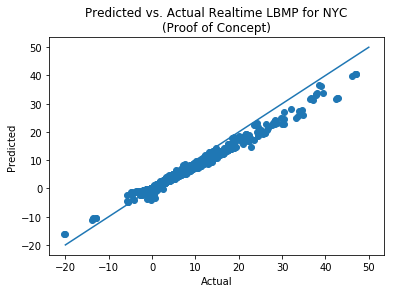

In [10]:
y_pred = ann.predict(x_test_scaled)

plt.scatter(y_test_scaled, y_pred)
# If our predictions were perfect, they'd fall exactly on this line.
plt.plot([-20, 50], [-20,50])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual Realtime LBMP for NYC\n(Proof of Concept)')
plt.show()